In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


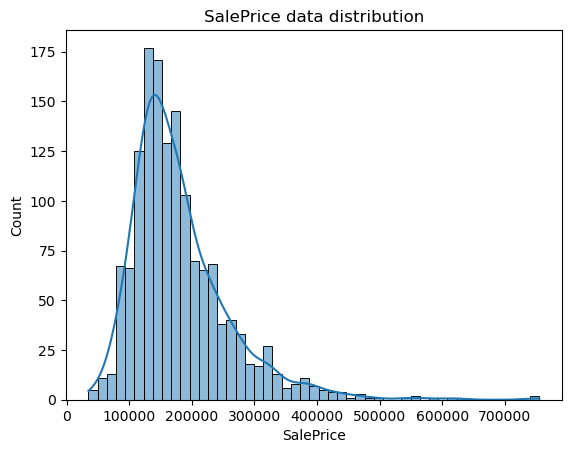

In [4]:
sns.histplot(x=train['SalePrice'], kde=True)
plt.title('SalePrice data distribution')
plt.show()

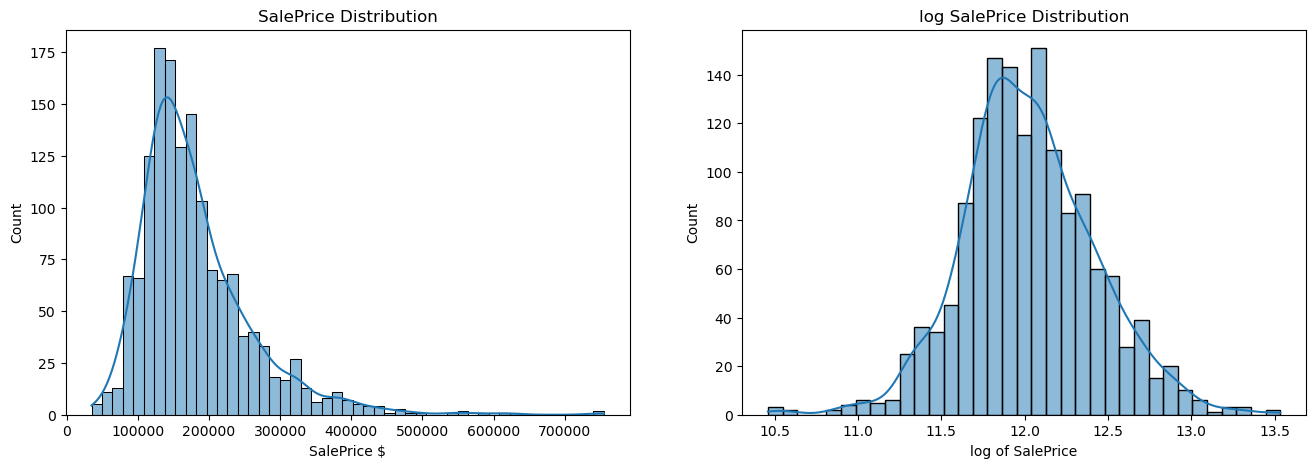

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
sns.histplot(x=train['SalePrice'], kde=True, ax=ax[0])
sns.histplot(x=np.log1p(train['SalePrice']), kde=True, ax=ax[1])
ax[0].set(title='SalePrice Distribution', xlabel='SalePrice $')
ax[1].set(title='log SalePrice Distribution', xlabel='log of SalePrice')
plt.show()

In [13]:
X = train.drop(columns=['SalePrice', 'Id'], axis=1)
X_test = test.drop(columns=['Id'], axis=1)
y = np.log1p(train['SalePrice'])

## Pipeline for data imputation and onehotencoding and normalization

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

In [34]:
def get_preprocessor(train_df, test_df=None):
    # pipeline for numeric column 
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )
    
    # pipeline for categorical column
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
#         OneHotEncoder(drop='if_binary', handle_unknown='ignore')
#         LabelEncoder()
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

    )
    
    # Separate numerical and categorical column
    numeric_columns = train_df.select_dtypes(exclude='object').columns
    categorical_columns = train_df.select_dtypes(include='object').columns
    
    # combine pipeline using columntransformer
    preprocessor = ColumnTransformer(
        transformers= [
            ('num', numeric_transformer, numeric_columns),
            ('cat', categorical_transformer, categorical_columns)
        ]
    )
    
    # Fit the preprocessor on the training data
    preprocessor.fit(train_df)
    
    # Transform the training data
    train_transformed = preprocessor.transform(train_df)
    
    # Convert sparse matrix to dense format if necessary
    if hasattr(train_transformed, "toarray"):
        train_transformed = train_transformed.toarray()
    
    # Get the features names
    feature_names = preprocessor.get_feature_names_out()
    
    # Convert to DataFrame
    preprocessed_train = pd.DataFrame(train_transformed, columns=feature_names)
    
    # If test data is provided, transform it using the fitted preprocessor
    if test_df is not None:
        test_transformed = preprocessor.transform(test_df)
        if hasattr(test_transformed, "toarray"):
            test_transformed = test_transformed.toarray()
        preprocessed_test = pd.DataFrame(test_transformed, columns=feature_names)
        return preprocessed_train, preprocessed_test
    
    return preprocessed_train



In [35]:
X_prep, test_prep = get_preprocessor(X, X_test)

In [36]:
X_prep

,num__MSSubClass,num__LotFrontage,num__LotArea,num__OverallQual,num__OverallCond,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,...,cat__GarageType,cat__GarageFinish,cat__GarageQual,cat__GarageCond,cat__PavedDrive,cat__PoolQC,cat__Fence,cat__MiscFeature,cat__SaleType,cat__SaleCondition
0,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
2,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
3,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,5.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
4,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073375,-0.357114,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1456,-0.872563,0.687385,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,0.722112,...,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1457,0.309859,-0.175462,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,0.0,2.0,8.0,4.0
1458,-0.872563,-0.084636,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,6.092188,...,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0


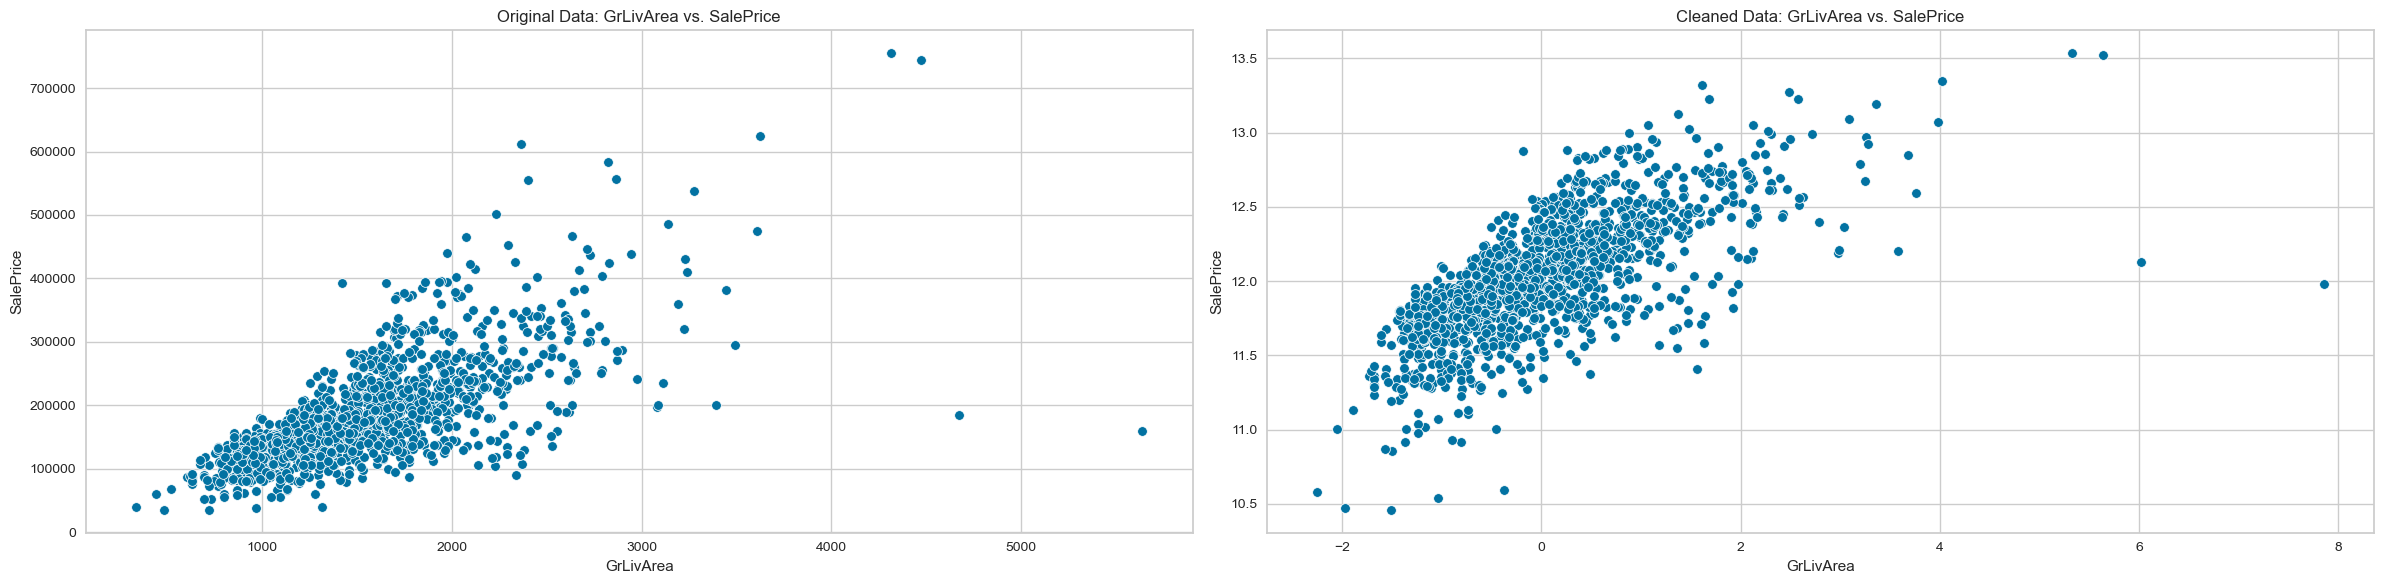

In [37]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Original Data
sns.scatterplot(ax=axes[0], x=train['GrLivArea'], y=train['SalePrice'])
axes[0].set_title('Original Data: GrLivArea vs. SalePrice')
axes[0].set_xlabel('GrLivArea')
axes[0].set_ylabel('SalePrice')

# Cleaned Data
sns.scatterplot(ax=axes[1], x=X_prep['num__GrLivArea'], y=y)
axes[1].set_title('Cleaned Data: GrLivArea vs. SalePrice')
axes[1].set_xlabel('GrLivArea')
axes[1].set_ylabel('SalePrice')

# Show plots
plt.tight_layout()
plt.show()

In [38]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_prep, y, test_size=0.2, random_state=42)

In [39]:
from pycaret import *
from pycaret.regression import *

In [40]:
exp_1 = setup(data=X_prep, target=y)
best_model = compare_models()

,Description,Value
0,Session id,1488
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 80)"
4,Transformed data shape,"(1460, 80)"
5,Transformed train set shape,"(1021, 80)"
6,Transformed test set shape,"(439, 80)"
7,Numeric features,79
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0884,0.0158,0.1247,0.9030,0.0097,0.0074,0.0450
br,Bayesian Ridge,0.0888,0.0161,0.1258,0.9014,0.0098,0.0074,0.0040
ridge,Ridge Regression,0.0895,0.0163,0.1265,0.9003,0.0099,0.0075,0.0040
lr,Linear Regression,0.0915,0.0168,0.1283,0.8970,0.0100,0.0077,0.1880
et,Extra Trees Regressor,0.0940,0.0184,0.1341,0.8884,0.0104,0.0079,0.0780
rf,Random Forest Regressor,0.0953,0.0189,0.1357,0.8853,0.0106,0.0080,0.0980
xgboost,Extreme Gradient Boosting,0.0985,0.0205,0.1418,0.8747,0.0111,0.0083,0.0420
lar,Least Angle Regression,0.1091,0.0236,0.1518,0.8500,0.0118,0.0091,0.0050
omp,Orthogonal Matching Pursuit,0.1216,0.0270,0.1631,0.8365,0.0127,0.0102,0.0040
ada,AdaBoost Regressor,0.1250,0.0273,0.1636,0.8356,0.0127,0.0104,0.0240


In [48]:
y_pred = best_model.predict(test_prep)

In [49]:
sub_pred = np.exp(y_pred)

In [50]:
# Create a DataFrame for submission
submission_df = pd.DataFrame({'Id': test['Id'], 'SalePrice': sub_pred})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('sample_submission.csv', index=False)

In [44]:
tune_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0945,0.0185,0.1360,0.9123,0.0107,0.0079
1,0.0852,0.0129,0.1137,0.9086,0.0088,0.0071
2,0.0928,0.0133,0.1154,0.9117,0.0089,0.0077
3,0.0953,0.0198,0.1407,0.8514,0.0110,0.0080
4,0.0625,0.0073,0.0852,0.9493,0.0065,0.0052
5,0.0848,0.0158,0.1259,0.9055,0.0101,0.0072
6,0.0921,0.0191,0.1383,0.9155,0.0108,0.0077
7,0.0754,0.0100,0.1002,0.9374,0.0077,0.0063
8,0.0940,0.0151,0.1230,0.8849,0.0095,0.0078


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [45]:
y_pred = tune_model.predict(test_prep)